In [1]:
# Twitter Sentiment Analysis

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from joblib import Parallel, delayed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB,ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

In [16]:
train = pd.read_csv('Train.csv')
submission = pd.read_csv('zSample_Submission.csv')
test = pd.read_csv('Test.csv')

In [17]:
train.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049158578504916992,@Vini_Arisato eu espero que não,Mon Oct 08 04:44:32 +0000 2018,0,:(
1,1049104603332169728,me diz aí o que vai ser do serviço social com ...,Mon Oct 08 01:10:03 +0000 2018,1,:)
2,1050780236856651776,"inclusive, os nomes que eu uso aqui são de tes...",Fri Oct 12 16:08:25 +0000 2018,1,:)
3,1047555890654728192,@rangerlol1 Hora da panelinha começar a passar...,Wed Oct 03 18:36:01 +0000 2018,1,:)
4,1046965203701829632,Meu neosoro tá acabando,Tue Oct 02 03:28:50 +0000 2018,0,:(


In [18]:
test.head()

,id,tweet_text,tweet_date
0,1029570266916159488,@Ataylandia vc paga o meu e eu como o seu tau...,Wed Aug 15 03:27:34 +0000 2018
1,1030496040649142272,a mão ((((((( https://t.co/cdBTzTVCt6,Fri Aug 17 16:46:16 +0000 2018
2,1030496928755314688,@delucca geralmente a depressão é filha da ans...,Fri Aug 17 16:49:48 +0000 2018
3,1029559076815097856,SUPER INDICO!!! GRANDE PROFISSIONAL https://t...,Wed Aug 15 02:43:06 +0000 2018
4,1029551213866573830,@Leticia75917877 Boa sorte,Wed Aug 15 02:11:52 +0000 2018


In [19]:
submission.head()

,id,sentiment
0,147852369874563210,1
1,102030405060708090,0
2,1020304050607080900,1
3,1234567899852147821,0
4,4002892240028922400,1


In [20]:
submission=test

In [21]:
train.shape, test.shape, submission.shape


((50000, 5), (5000, 3), (5000, 3))

In [22]:
value_counts=train['sentiment'].value_counts()

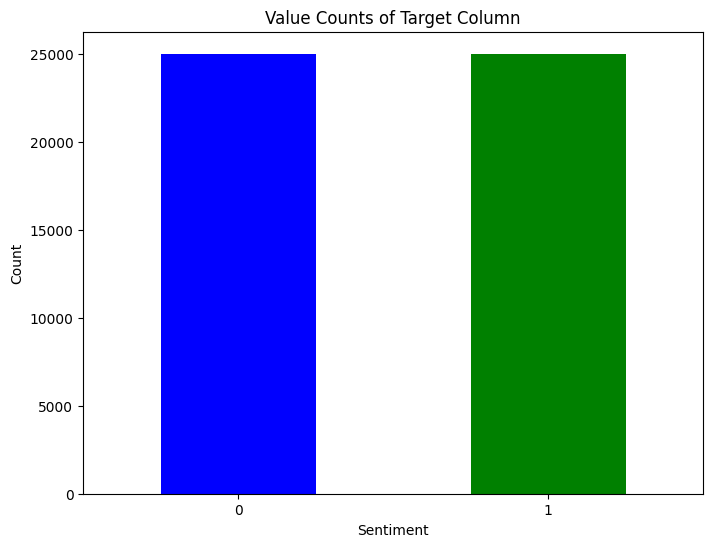

In [23]:
plt.figure(figsize=(8,6))
value_counts.plot(kind='bar', color=['blue','green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Value Counts of Target Column')
plt.xticks(rotation=0)
plt.show()

In [24]:
train=train[['tweet_text','sentiment']]

In [25]:
df=pd.concat([train,test],ignore_index=True)

In [26]:
df.head()

,tweet_text,sentiment,id,tweet_date
0,@Vini_Arisato eu espero que não,0.0,NaN,NaN
1,me diz aí o que vai ser do serviço social com ...,1.0,NaN,NaN
2,"inclusive, os nomes que eu uso aqui são de tes...",1.0,NaN,NaN
3,@rangerlol1 Hora da panelinha começar a passar...,1.0,NaN,NaN
4,Meu neosoro tá acabando,0.0,NaN,NaN


In [27]:
df=df[['tweet_text','sentiment']]

In [28]:
df.isnull().sum()

,0
tweet_text,0
sentiment,5000


In [29]:
df['tweet_text']=df['tweet_text'].str.lower() # kücük harfe cevrildi.

In [30]:
df['tweet_text']=df['tweet_text'].str.replace('[^\w\s]','')
df['tweet_text']=df['tweet_text'].str.replace('\n','')
df['tweet_text']=df['tweet_text'].str.replace('\d+','')
df['tweet_text']=df['tweet_text'].str.replace('\r','')

In [36]:
def tokenization(text):
    text=re.split('\W+',text)
    return text

In [37]:
df['tokenization']=df['tweet_text'].apply(lambda x:tokenization(x.lower()))
df.head()

,tweet_text,sentiment,tokenization
0,@vini_arisato eu espero que não,0.0,"[, vini_arisato, eu, espero, que, não, ]"
1,me diz aí o que vai ser do serviço social com ...,1.0,"[me, diz, aí, o, que, vai, ser, do, serviço, s..."
2,"inclusive, os nomes que eu uso aqui são de tes...",1.0,"[inclusive, os, nomes, que, eu, uso, aqui, são..."
3,@rangerlol1 hora da panelinha começar a passar...,1.0,"[, rangerlol1, hora, da, panelinha, começar, a..."
4,meu neosoro tá acabando,0.0,"[meu, neosoro, tá, acabando, ]"


In [38]:
# portekiz tweetleri
nltk.download('stopwords')
stopword=nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

In [40]:
df['nonstop']=df['tokenization'].apply(lambda x:remove_stopwords(x))
df.head(20)

,tweet_text,sentiment,tokenization,nonstop
0,@vini_arisato eu espero que não,0.0,"[, vini_arisato, eu, espero, que, não, ]","[, vini_arisato, espero, ]"
1,me diz aí o que vai ser do serviço social com ...,1.0,"[me, diz, aí, o, que, vai, ser, do, serviço, s...","[diz, aí, vai, serviço, social, bolsonaro, pod..."
2,"inclusive, os nomes que eu uso aqui são de tes...",1.0,"[inclusive, os, nomes, que, eu, uso, aqui, são...","[inclusive, nomes, uso, aqui, teste, tá, ahdjs..."
3,@rangerlol1 hora da panelinha começar a passar...,1.0,"[, rangerlol1, hora, da, panelinha, começar, a...","[, rangerlol1, hora, panelinha, começar, passa..."
4,meu neosoro tá acabando,0.0,"[meu, neosoro, tá, acabando, ]","[neosoro, tá, acabando, ]"
5,@unodded eu queria mt aproveitar a minha pra r...,0.0,"[, unodded, eu, queria, mt, aproveitar, a, min...","[, unodded, queria, mt, aproveitar, pra, rodar..."
6,oi gnt vcs sabem que vcs tem que ver o context...,1.0,"[oi, gnt, vcs, sabem, que, vcs, tem, que, ver,...","[oi, gnt, vcs, sabem, vcs, ver, contexto, piad..."
7,@alientivo_ assim como vc tem um lugarzinho no...,0.0,"[, alientivo_, assim, como, vc, tem, um, lugar...","[, alientivo_, assim, vc, lugarzinho, saudades..."
8,@danielsouzaluz nossa que ótima notícia. )),1.0,"[, danielsouzaluz, nossa, que, ótima, notícia, ]","[, danielsouzaluz, ótima, notícia, ]"
9,porra pk que não percebes que sou feliz é cont...,0.0,"[porra, pk, que, não, percebes, que, sou, feli...","[porra, pk, percebes, feliz, contigo, outra, p..."


In [41]:
ps=nltk.PorterStemmer()
def stemming(text):
    text=[ps.stem(word) for word in text]
    return text

In [42]:
df['stemmed']=df['nonstop'].apply(lambda x:stemming(x))
df.head()

,tweet_text,sentiment,tokenization,nonstop,stemmed
0,@vini_arisato eu espero que não,0.0,"[, vini_arisato, eu, espero, que, não, ]","[, vini_arisato, espero, ]","[, vini_arisato, espero, ]"
1,me diz aí o que vai ser do serviço social com ...,1.0,"[me, diz, aí, o, que, vai, ser, do, serviço, s...","[diz, aí, vai, serviço, social, bolsonaro, pod...","[diz, aí, vai, serviço, social, bolsonaro, pod..."
2,"inclusive, os nomes que eu uso aqui são de tes...",1.0,"[inclusive, os, nomes, que, eu, uso, aqui, são...","[inclusive, nomes, uso, aqui, teste, tá, ahdjs...","[inclus, nome, uso, aqui, test, tá, ahdjshsj, ..."
3,@rangerlol1 hora da panelinha começar a passar...,1.0,"[, rangerlol1, hora, da, panelinha, começar, a...","[, rangerlol1, hora, panelinha, começar, passa...","[, rangerlol1, hora, panelinha, começar, passa..."
4,meu neosoro tá acabando,0.0,"[meu, neosoro, tá, acabando, ]","[neosoro, tá, acabando, ]","[neosoro, tá, acabando, ]"


In [43]:
def clean_text(text):
  text_lc="".join([word.lower() for word in text if word not in string.punctuation]) # remove
  text_rc=re.sub('[0-9]+','',text_lc)
  tokens=re.split('\W+',text_rc) #tokenization

In [45]:
df['stemmedtext']=df['stemmed'].apply(lambda x:''.join(x))
df.head()

,tweet_text,sentiment,tokenization,nonstop,stemmed,stemmedtext
0,@vini_arisato eu espero que não,0.0,"[, vini_arisato, eu, espero, que, não, ]","[, vini_arisato, espero, ]","[, vini_arisato, espero, ]",vini_arisatoespero
1,me diz aí o que vai ser do serviço social com ...,1.0,"[me, diz, aí, o, que, vai, ser, do, serviço, s...","[diz, aí, vai, serviço, social, bolsonaro, pod...","[diz, aí, vai, serviço, social, bolsonaro, pod...",dizaívaiserviçosocialbolsonaropoder
2,"inclusive, os nomes que eu uso aqui são de tes...",1.0,"[inclusive, os, nomes, que, eu, uso, aqui, são...","[inclusive, nomes, uso, aqui, teste, tá, ahdjs...","[inclus, nome, uso, aqui, test, tá, ahdjshsj, ...",inclusnomeusoaquitesttáahdjshsjaindatôtestando...
3,@rangerlol1 hora da panelinha começar a passar...,1.0,"[, rangerlol1, hora, da, panelinha, começar, a...","[, rangerlol1, hora, panelinha, começar, passa...","[, rangerlol1, hora, panelinha, começar, passa...",rangerlol1horapanelinhacomeçarpassarpanofaland...
4,meu neosoro tá acabando,0.0,"[meu, neosoro, tá, acabando, ]","[neosoro, tá, acabando, ]","[neosoro, tá, acabando, ]",neosorotáacabando


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB,ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier

In [47]:
from nltk.stem import PorterStemmer
pr=PorterStemmer

In [49]:
def lemmafn(text):
    words=TextBlob(text).words
    return[pr.stem(word) for word in words]

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10000, analyzer=lemmafn)

In [51]:
vect

CountVectorizer(analyzer=<function lemmafn at 0x7c485878dee0>,
                max_features=10000, ngram_range=(1, 2), stop_words='english')

In [52]:
train=df.iloc[:5000]
test=df.iloc[5000:]

In [54]:
x_train=train.stemmedtext
y_train=train['sentiment']
x_test=test.stemmedtext
y_test=test['sentiment']

In [68]:
from textblob import TextBlob
x_train=vect.fit_transform(x_train)

In [75]:
def fnc_classification_all_model(x,y):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    import imblearn
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
    from sklearn.metrics import confusion_matrix, classification_report

In [76]:
g=GaussianNB()
b=BernoulliNB()
D=DecisionTreeClassifier()
R=RandomForestClassifier()
G=GradientBoostingClassifier()
Log=LogisticRegression()
XGB=XGBClassifier()

In [78]:
# Split the data into training and testing sets before vectorization
from sklearn.model_selection import train_test_split

# Use the full dataframe with stemmed text and sentiment
x = df.stemmedtext
y = df['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) # Example split ratio

# Now vectorize the training data and transform the testing data
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob # Import TextBlob if it's used in analyzer

# Make sure the PorterStemmer is available in the scope or imported within lemmafn if needed
# from nltk.stem import PorterStemmer
# pr=PorterStemmer() # Instantiate the stemmer

# Define or ensure lemmafn is correctly defined and uses pr
# def lemmafn(text):
#     words=TextBlob(text).words
#     return[pr.stem(word) for word in words]

# Define the vectorizer
vect=CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10000, analyzer=lemmafn)

# Fit and transform the training data
x_train_vec = vect.fit_transform(x_train)

# Transform the testing data
x_test_vec = vect.transform(x_test)

# Now use x_train_vec, y_train, x_test_vec, y_test for training and evaluation

In [79]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)

In [80]:
algos=[b,D,R,Log,XGB,G]
algo_names=['BernoulliNB','DecisionTreeClassifier','RandomForestClassifier','LogisticRegression','XGBClassifier','GradientBoostingClassifier']


In [98]:
 %%
# Initialize empty lists for metrics
accuracy_scores = [] # Renamed variables to avoid conflict with imported functions
precision_scores = []
recall_scores = []
f1_scores = []

# Import metric functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for item, name in zip(algos, algo_names):
    print(f"Training and evaluating: {name}")

    try:
        # Fit the model on the vectorized training data and predict on the vectorized testing data
        item.fit(x_train_vec, y_train)
        predict = item.predict(x_test_vec)

        # Calculate and append the metrics
        accuracy_scores.append(accuracy_score(y_test, predict))
        precision_scores.append(precision_score(y_test, predict, average='macro'))
        recall_scores.append(recall_score(y_test, predict, average='macro'))
        f1_scores.append(f1_score(y_test, predict, average='macro'))

    except Exception as e:
        print(f"Error training or evaluating {name}: {e}")
        # Append NaN or None to the lists if an error occurs
        accuracy_scores.append(np.nan)
        precision_scores.append(np.nan)
        recall_scores.append(np.nan)
        f1_scores.append(np.nan)


# Create a DataFrame with the results
result = pd.DataFrame(list(zip(algo_names, accuracy_scores, precision_scores, recall_scores, f1_scores)),
                      columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Display the result dataframe sorted by F1 Score
print("\nClassification Results:")
display(result.sort_values('F1 Score',ascending=False))

UsageError: Cell magic `%%` not found.


In [99]:
fnc_classification_all_model(x_train,y_train)

In [103]:
BernoulliNB()
DecisionTreeClassifier()
BernoulliNB()
DecisionTreeClassifier()
BernoulliNB()
DecisionTreeClassifier()
BernoulliNB()
DecisionTreeClassifier()
RandomForestClassifier()
LogisticRegression()
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,colsampl

IndentationError: unexpected indent (<ipython-input-103-b5c7fc053d9b>, line 48)